# Time Causal VAE

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import yaml
sys.path.append('../src')
sys.path.append('../../../..')
from tsvae.utils.logger_utils import get_console_logger
logger = get_console_logger(__name__)
from os import path as pt
from data_processing.post_processing import post_processing
from data_processing.config import post_processing_config
from models.DeepHedger import hedging

## Data used in original paper

(2516, 2)


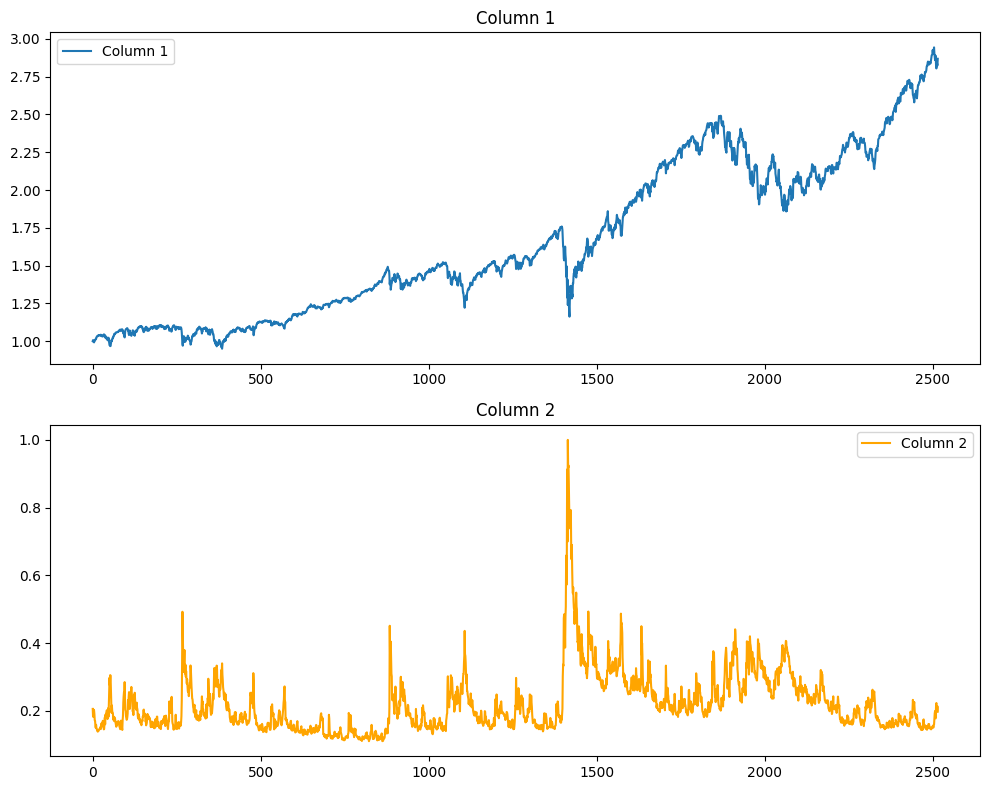

In [2]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("../data/sp500vix/sp500vix_normalized.npy")
print(data.shape)
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(data[:, 0], label="Column 1")
axs[0].set_title("Column 1")
axs[0].legend()

axs[1].plot(data[:, 1], label="Column 2", color="orange")
axs[1].set_title("Column 2")
axs[1].legend()

plt.tight_layout()
plt.show()


## Create Data for Master Thesis

In [16]:
import numpy as np
import pandas as pd

train_data = pd.read_csv("../../../../../data/raw/spy_daily_closing_prices_train.csv", index_col = 0)
# df["vol"] = df["Close"].rolling(window=30).std()
# df = df.dropna()
price_scaler = data[0, 0]
vol_scaler = np.max(data[:, 1])
data = df.to_numpy()
data[:, 0] = data[:, 0]/price_scaler
data[:, 1] = data[:, 1]/vol_scaler
print(data.shape)
np.save("../data/sp500vix/sp500_normalized.npy", data)



(1089, 2)


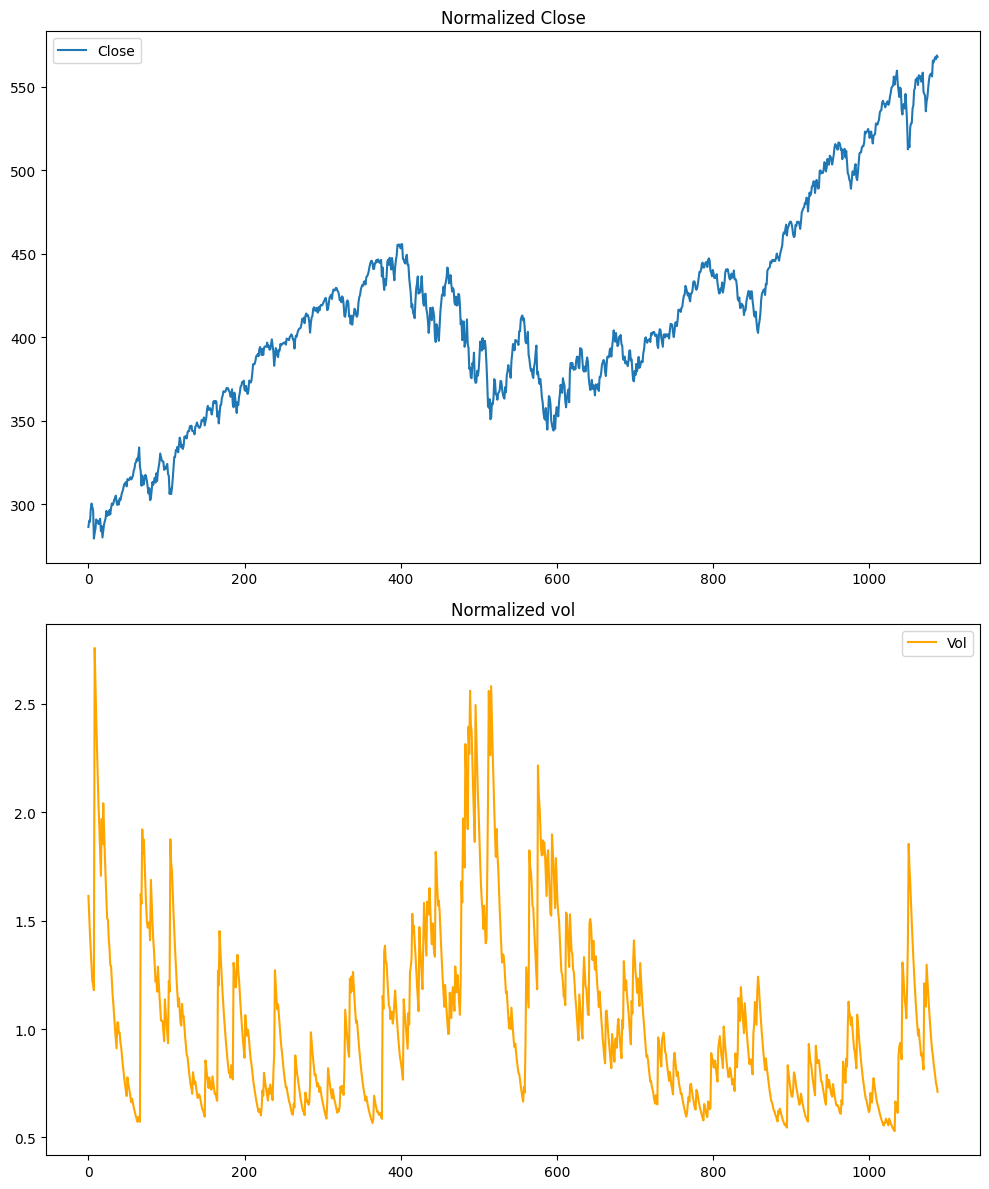

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

axs[0].plot(data[:, 0], label="Close")
axs[0].set_title("Normalized Close")
axs[0].legend()

axs[1].plot(data[:, 1], label="Vol", color="orange")
axs[1].set_title("Normalized vol")
axs[1].legend()

# axs[2].plot(rolling_volatility, label="30-Day Rolling Volatility", color="green")
# axs[2].set_title("30-Day Rolling Volatility of Column 1")
# axs[2].legend()

plt.tight_layout()
plt.show()

## TCVAE Model

In [5]:
from experiments.experiment_utils import get_output_dir, update_config
from tsvae.dataset.data_pipeline import DataPipeline
from tsvae.models.network_pipeline import NetworkPipeline
from tsvae.utils.random_utils import set_seed


base_output_dir = '..' 
new_config = {'epochs' : 100, 'wandb': False, 'comment': 'test'}
exp_config_path = '../configs/Master/betacvae.yaml'

with open(exp_config_path) as file:
    exp_config = dict(yaml.safe_load(file))

exp_config = update_config(exp_config, new_config)

exp_config.base_output_dir = base_output_dir
exp_config.output_dir = get_output_dir(exp_config)
logger.info(f"Experiment results saved to {exp_config.output_dir}")

logger.info(f"Saving experiment config to {exp_config.output_dir}")
config_file_path = pt.join(exp_config.output_dir, "exp_config.yaml")
with open(config_file_path, "w") as outfile:
    yaml.dump(exp_config, outfile, default_flow_style=False)
# logger.info(exp_config)

# Generating data
logger.info(f"Setting ramdom seed: {exp_config.seed}")
set_seed(exp_config.seed)

Experiment results saved to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Saving experiment config to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Setting ramdom seed: 0


In [6]:
logger.info(f"Loading dataset: {exp_config.dataset}")
data_pipeline = DataPipeline()
train_dataset, eval_dataset = data_pipeline(exp_config)

# Loading network
logger.info("Load networks:")
network_pipeline = NetworkPipeline()
model = network_pipeline(exp_config)
# logger.info(f"{model}")

Loading dataset: Master
Base dataset initialized
Load networks:


In [7]:
from tsvae.trainers.base_trainer_config import BaseTrainerConfig
from tsvae.trainers.training_pipeline import TrainingPipeline


training_config = BaseTrainerConfig(
    output_dir=exp_config.output_dir,
    learning_rate=exp_config.lr,
    per_device_train_batch_size=exp_config.train_batch_size,
    per_device_eval_batch_size=exp_config.eval_batch_size,
    optimizer_cls=exp_config.optimizer,
    optimizer_params=None,
    scheduler_cls=None,
    scheduler_params=None,
    steps_saving=exp_config.steps_saving,
    steps_predict=exp_config.steps_predict,
    seed=exp_config.seed,
    num_epochs=exp_config.epochs,
    wandb_callback=exp_config.wandb,
    wandb_output_dir=exp_config.base_output_dir + "/wandb",
)

train_pipeline = TrainingPipeline(model=model, training_config=training_config, exp_config=exp_config)

trainer = train_pipeline(
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    device_name=exp_config.device_name,
)

Path Visualization of data
Model passed sanity check !
Ready for training.



In [8]:
train_pipeline.train(log_output=True)

Created ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test/BetaCVAE_training_2025-04-22_09-28-15. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: 30
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.002797303101232966
    maximize: False
    weight_decay: 0
)
Scheduler: None
Device: cpu

Successfully launched training !

Training of epoch 1/100: 100%|██████████| 5/5 [00:00<00:00, 21.43batch/s]total loss: 2.87
recon: 2.68
reg: 4.75
Eval of epoch 1/100:  20%|██        | 1/5 [00:00<00:00,  5.85batch/s]
--------------------------------------------------------------------------
Train loss: 5.7116
--------------------------------------------------

In [ ]:
from evaluations.hyperparameter import ModelEvaluator
from os import path as pt

model_dir = pt.join(trainer.training_dir, 'final_model')
model_evaluator = ModelEvaluator(model_dir)
output_dir = model_evaluator.hyper_model_dir
model = model_evaluator.model

# test_data, gen_data, recon_data = model_evaluator.load_data(seed = 99, n_sample_test=1000)
# ds = model_evaluator.data_ppl.base_dataset

# real_data = test_data
# recon_data = recon_data
# fake_data = gen_data


df_tot_fake = pd.DataFrame()
# 100 times 1000 corresponds to M = 100.000
print("Generating data")
for i in range(100):
    test_data, gen_data, recon_data = model_evaluator.load_data(seed = i, n_sample_test=1000)
    ds = model_evaluator.data_ppl.base_dataset

    real_data = test_data
    recon_data = recon_data
    fake_data = gen_data

    df_sub_fake = pd.DataFrame(gen_data.detach().squeeze(-1).numpy())
    df_tot_fake = pd.concat([df_tot_fake, df_sub_fake], axis=0)

In [17]:
df_tot_fake = df_tot_fake.reset_index(drop=True)
df_post_processed = post_processing(df_tot_fake, **post_processing_config)

## Real Data (l) and Fake Data (r)

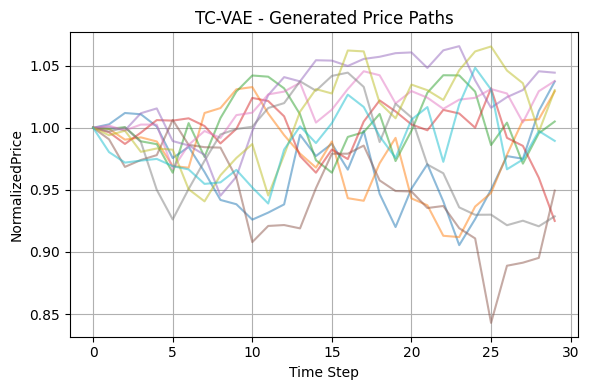

In [27]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

# Plot post-processed paths
for i in range(10):
    axs.plot(df_post_processed.iloc[i, :], alpha=0.5)


axs.set_title('TC-VAE - Generated Price Paths')
axs.set_xlabel('Time Step')
axs.set_ylabel('NormalizedPrice')
axs.grid(True)

plt.tight_layout()
plt.show()


In [24]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualization(ori_data, generated_data, analysis, data_generating_model, compare=3000):
    """Using PCA or tSNE for generated and original data visualization.
  
  Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca or kernel
  """
    # Analysis sample size (for faster computation)
    anal_sample_no = min([compare, ori_data.shape[0]])
    idx = np.random.permutation(ori_data.shape[0])[:anal_sample_no]

    # Data preprocessing
    # ori_data = np.asarray(ori_data)
    # generated_data = np.asarray(generated_data)

    ori_data = ori_data[idx]
    generated_data = generated_data[idx]

    no, seq_len, dim = ori_data.shape

    for i in range(anal_sample_no):
        if (i == 0):
            prep_data = np.reshape(np.mean(ori_data[0, :, :], 1), [1, seq_len])
            prep_data_hat = np.reshape(np.mean(generated_data[0, :, :], 1), [1, seq_len])
        else:
            prep_data = np.concatenate((prep_data,
                                        np.reshape(np.mean(ori_data[i, :, :], 1), [1, seq_len])))
            prep_data_hat = np.concatenate((prep_data_hat,
                                            np.reshape(np.mean(generated_data[i, :, :], 1), [1, seq_len])))

    # Visualization parameter
    colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]

    if analysis == 'pca':
        # PCA Analysis
        pca = PCA(n_components=2)
        pca.fit(prep_data)
        pca_results = pca.transform(prep_data)
        pca_hat_results = pca.transform(prep_data_hat)

        # Plotting
        f, ax = plt.subplots(1)
        plt.scatter(pca_results[:, 0], pca_results[:, 1],
                    c=colors[:anal_sample_no], alpha=0.2, label="Original")
        plt.scatter(pca_hat_results[:, 0], pca_hat_results[:, 1],
                    c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")

        ax.legend()
        plt.title(f'PCA plot for {data_generating_model}')
        plt.xlabel('x-pca')
        plt.ylabel('y-pca')
        plt.show()

    elif analysis == 'tsne':

        # Do t-SNE Analysis together
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)

        # TSNE anlaysis
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(prep_data_final)

        # Plotting
        f, ax = plt.subplots(1)

        plt.scatter(tsne_results[:anal_sample_no, 0], tsne_results[:anal_sample_no, 1],
                    c=colors[:anal_sample_no], alpha=0.2, label="Original")
        plt.scatter(tsne_results[anal_sample_no:, 0], tsne_results[anal_sample_no:, 1],
                    c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")

        ax.legend()

        plt.title(f't-SNE plot for {data_generating_model}')
        plt.xlabel('x-tsne')
        plt.ylabel('y-tsne')
        plt.show()

    elif analysis == 'kernel':
       
        # Visualization parameter
        # colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]

        f, ax = plt.subplots(1)
        sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
        sns.distplot(prep_data_hat, hist=False, kde=True, kde_kws={'linewidth': 5, 'linestyle':'--'}, label='Synthetic', color="blue")
        # Plot formatting

        # plt.legend(prop={'size': 22})
        plt.legend()
        plt.xlabel('Data Value')
        plt.ylabel('Data Density Estimate')
        # plt.rcParams['pdf.fonttype'] = 42

        # plt.savefig(str(args.save_dir)+"/"+args.model1+"_histo.png", dpi=100,bbox_inches='tight')
        # plt.ylim((0, 12))
        plt.show()
        plt.close()

(1060, 30, 1)
(100000, 30, 1)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2120 samples in 0.000s...
[t-SNE] Computed neighbors for 2120 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2120
[t-SNE] Computed conditional probabilities for sample 2000 / 2120
[t-SNE] Computed conditional probabilities for sample 2120 / 2120
[t-SNE] Mean sigma: 0.035205


/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.857460
[t-SNE] KL divergence after 300 iterations: 1.887835


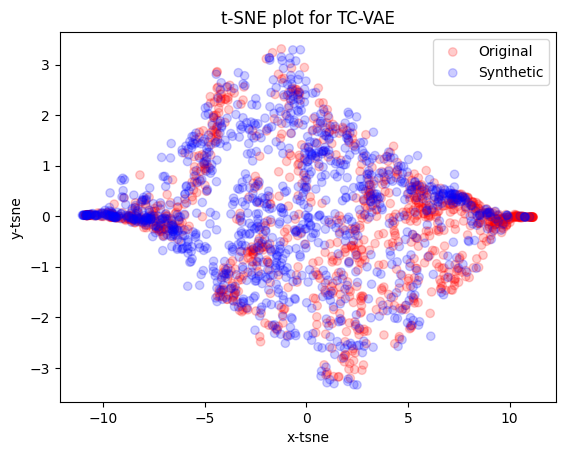

In [29]:
sys.path.append('../../../..')
from data_processing.post_processing import post_processing
from data_processing.config import post_processing_config

from notebooks.visualisation import visualization

train_data_vis = np.array(train_data[["Close"]].values)
train_data_vis = np.array([train_data_vis[i:i+30] for i in range(len(train_data_vis)-30 + 1)])
train_data_vis = train_data_vis / train_data_vis[:, 0:1]

df_post_processed_vis = np.array(df_post_processed.values)
df_post_processed_vis = df_post_processed_vis[..., np.newaxis]

print(train_data_vis.shape)
print(df_post_processed_vis.shape)

visualization(ori_data=train_data_vis, generated_data=df_post_processed_vis, analysis='tsne', data_generating_model="TC-VAE", compare=train_data_vis.shape[0])